In [22]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


C:\Users\Asus\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['close', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [23]:
import os
from sklearn.metrics import roc_curve, auc, confusion_matrix
from matplotlib import animation
import matplotlib.patches as mpatches
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


class DataPreprocessor:
    def __init__(self):
        pass

    def CustomSmoother(self, x, alpha):
        s0 = x[0]
        smoothed_statistic = [s0]
        n = x.shape[0]
        for i in range(1, n):
            s1 = alpha * x[i] + (1 - alpha) * s0
            smoothed_statistic.append(s1)
            s0 = s1
        smoothed_statistic = np.array(smoothed_statistic)
        return smoothed_statistic

    def PandaSmoother(self, x):
        return pd.DataFrame(x).ewm(span=20).mean()

class Evaluator:
    def __init__(self, X_test, y_test, y_pred, model):
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = y_pred
        self.model = model

    def confusion_matrix(self):
        self.cm = confusion_matrix(self.y_test, self.y_pred)

    def get_performance_metrics(self):
        self.confusion_matrix()

        accuracy = (
                float((self.cm[0][0] + self.cm[1][1])) /
                (self.cm[0][0] + self.cm[0][1] + self.cm[1][0] +
                 self.cm[1][1])
        )
        precision = (
                float((self.cm[1][1])) /
                (self.cm[1][1] + self.cm[0][1])
        )
        recall = (
                float((self.cm[1][1])) /
                (self.cm[1][1] + self.cm[1][0])
        )
        specificity = (
                float((self.cm[0][0])) /
                (self.cm[0][0] + self.cm[0][1])
        )

        return accuracy, recall, precision, specificity

    def draw_ROC(self, use_probabilities=True):
        y_prob = self.model.predict_proba(self.X_test)
        y_pred = self.model.predict(self.X_test)
        prob_estimate = y_prob[:, 1]
        
        if use_probabilities:
            fpr, tpr, threshold = roc_curve(self.y_test, prob_estimate)
        else:
            fpr, tpr, threshold = roc_curve(self.y_test, y_pred)
        area = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, linewidth=2.0, label="ROC curve (Area= %0.2f)" % area)
        plt.plot([0, 1], [0, 1], "r--")
        plt.xlabel("False Postive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")

    def oob_vs_n_trees(self, max_trees, X_train, y_train):
        # First set up the figure, the axis, and the plot element we want to animate
        print("")
        print("Number of Trees\t\tOOB Error Rate")
        fig = plt.figure()
        ax = plt.axes(xlim=(0, max_trees), ylim=(0, 1))
        line, = ax.plot([], [], lw=2)

        # initialization function: plot the background of each frame
        def init():
            line.set_data([], [])
            return line,

        number_of_trees = range(2, max_trees + 1)
        oob_errors = []

        # animation function.  This is called sequentially
        def animate(i):
            model = RandomForestClassifier(warm_start=True, oob_score=True, n_estimators=i)
            model.fit(X_train, y_train)
            oob_error = 1 - model.oob_score_
            oob_errors.append(oob_error)
            print("{}\t\t\t{}".format(i, oob_error))

            line.set_data(number_of_trees[:len(oob_errors)], oob_errors)
            return line,

        # call the animator.  blit=True means only re-draw the parts that have changed.
        anim = animation.FuncAnimation(fig, animate, init_func=init, frames=number_of_trees, interval=100, blit=True,
                                       repeat=False)
        plt.xlabel("Number of trees")
        plt.ylabel("OOB error")
        plt.show()

    def plot_classification_results(self):
        self.confusion_matrix()
        x = [i + 3.0 for i in range(4)]
        xlabel = ["TP", "FN", "FP", "TN"]
        plt.figure()
        plt.grid(True)
        plt.bar(x, self.cm.reshape(-1), color=np.random.random((4, 3)))
        plt.xticks([i + 3.0 for i in range(4)], xlabel)
        plt.show(block=False)

        
# exponential weighted moving average
def ema(x, p):
    x = x.squeeze()
    prev_ema = x[:p].mean()
    ema = [prev_ema]
    m = len(x)
    multiplier = 2 / float(p + 1)
    for i in range(p, m):
        cur_ema = (x[i] - prev_ema) * multiplier + prev_ema
        prev_ema = cur_ema
        ema.append(cur_ema)
    return np.array(ema)


# Relative Strength Index
def getRSI(x):
    x = x.squeeze()
    n = len(x)
    x0 = x[:n - 1]
    x1 = x[1:]
    change = x1 - x0
    avgGain = []
    avgLoss = []
    loss = 0
    gain = 0
    for i in range(14):
        if change[i] > 0:
            gain += change[i]
        elif change[i] < 0:
            loss += abs(change[i])
    averageGain = gain / 14.0
    averageLoss = loss / 14.0
    avgGain.append(averageGain)
    avgLoss.append(averageLoss)
    for i in range(14, n - 1):
        if change[i] >= 0:
            avgGain.append((avgGain[-1] * 13 + change[i]) / 14.0)
            avgLoss.append((avgLoss[-1] * 13) / 14.0)
        else:
            avgGain.append((avgGain[-1] * 13) / 14.0)
            avgLoss.append((avgLoss[-1] * 13 + abs(change[i])) / 14.0)
    avgGain = np.array(avgGain)
    avgLoss = np.array(avgLoss)
    RS = avgGain / avgLoss
    RSI = 100 - (100 / (1 + RS))
    return np.c_[RSI, x1[13:]]


def getStochasticOscillator(x):
    high = x[:, 1].squeeze()
    low = x[:, 2].squeeze()
    close = x[:, 3].squeeze()
    n = len(high)
    highestHigh = []
    lowestLow = []
    for i in range(n - 13):
        highestHigh.append(high[i:i + 14].max())
        lowestLow.append(low[i:i + 14].min())
    highestHigh = np.array(highestHigh)
    lowestLow = np.array(lowestLow)
    k = 100 * ((close[13:] - lowestLow) / (highestHigh - lowestLow))

    return np.c_[k, close[13:]]


def getWilliams(x):
    high = x[:, 1].squeeze()
    low = x[:, 2].squeeze()
    close = x[:, 3].squeeze()
    n = len(high)
    highestHigh = []
    lowestLow = []
    for i in range(n - 13):
        highestHigh.append(high[i:i + 14].max())
        lowestLow.append(low[i:i + 14].min())
    highestHigh = np.array(highestHigh)
    lowestLow = np.array(lowestLow)
    w = -100 * ((highestHigh - close[13:]) / (highestHigh - lowestLow))
    return np.c_[w, close[13:]]


def getMACD(close):
    ma1 = ema(close.squeeze(), 12)
    ma2 = ema(close.squeeze(), 26)
    macd = ma1[14:] - ma2
    return np.c_[macd, close[len(close) - len(macd):]]


def getPriceRateOfChange(close, n_days):
    close = close.squeeze()
    n = len(close)
    x0 = close[:n - n_days]
    x1 = close[n_days:]
    PriceRateOfChange = (x1 - x0) / x0
    return np.c_[PriceRateOfChange, x1]


def getOnBalanceVolume(X):
    close = X[:, 3].squeeze()
    volume = X[:, 4].squeeze()[1:]
    n = len(close)
    x0 = close[:n - 1]
    x1 = close[1:]
    change = x1 - x0
    OBV = []
    prev_OBV = 0

    for i in range(n - 1):
        if change[i] > 0:
            current_OBV = prev_OBV + volume[i]
        elif change[i] < 0:
            current_OBV = prev_OBV - volume[i]
        else:
            current_OBV = prev_OBV
        OBV.append(current_OBV)
        prev_OBV = current_OBV
    OBV = np.array(OBV)
    return np.c_[OBV, x1]

def getData(CSVFile, days=None):
    smoother = DataPreprocessor()
    data = pd.read_csv(CSVFile)
    data = data[::-1]  # reverse
    if days is not None:
        data = data[-days:]
    ohclv_data = np.c_[data['Open'],
                       data['High'],
                       data['Low'],
                       data['Close'],
                       data['Volume']]
    smoothened_ohclv_data = smoother.PandaSmoother(ohclv_data)
    return smoothened_ohclv_data, np.array(data["Close"]), list(data["Date"])


def getTechnicalIndicators(X, d):
    RSI = getRSI(X[:, 3])
    StochasticOscillator = getStochasticOscillator(X)
    Williams = getWilliams(X)

    MACD = getMACD(X[:, 3])
    PROC = getPriceRateOfChange(X[:, 3], d)
    OBV = getOnBalanceVolume(X)

    min_len = min(len(RSI),
                  len(StochasticOscillator),
                  len(Williams),
                  len(MACD),
                  len(PROC),
                  len(OBV))

    RSI = RSI[len(RSI) - min_len:]
    StochasticOscillator = StochasticOscillator[len(StochasticOscillator) - min_len:]
    Williams = Williams[len(Williams) - min_len:]
    MACD = MACD[len(MACD) - min_len:]
    PROC = PROC[len(PROC) - min_len:]
    OBV = OBV[len(OBV) - min_len:]

    feature_matrix = np.c_[RSI[:, 0],
                           StochasticOscillator[:, 0],
                           Williams[:, 0],
                           MACD[:, 0],
                           PROC[:, 0],
                           OBV[:, 0]]

    return feature_matrix


def prepareData(X, close, date, days):

    feature_matrix = getTechnicalIndicators(X, days)

    print("Size of feature matrix: ", feature_matrix.shape)

    number_of_samples = feature_matrix.shape[0]
    print("Number of samples: %d" % number_of_samples)
    date = date[len(date) - number_of_samples:]
    close = close[len(close) - number_of_samples:]

    # y0 = feature_matrix[:,-1][ :number_of_samples-d]
    # y1 = feature_matrix[:,-1][d:]

    y0 = close[:number_of_samples - days]
    y1 = close[days:]

    feature_matrix_1 = feature_matrix[:number_of_samples - days]
    feature_matrix_2 = feature_matrix[number_of_samples - 1000:]
    date = date[number_of_samples - 1000:]

    # closeplot = feature_matrix[:,-1][number_of_samples - 1000:]
    closeplot = close[number_of_samples - 1000:]
    y = np.sign(y1 - y0)

    print("y: ", y)

    feature_matrix_1 = feature_matrix_1[:, range(6)]

    return feature_matrix_1, y, feature_matrix_2[:, range(6)], closeplot, date


def plotTradingStrategy(model, xplot, closeplot, Trading_Day, date):
    colorMap = {-1.0: "r", 1.0: "b", 0.0: "y"}
    tradeMap = {-1.0: "Sell", 1.0: "Buy", 0.0: "Buy"}
    plt.figure()
    plt.plot(closeplot, c="g")
    x = [xplot[i] for i in range(0, len(xplot), Trading_Day)]
    y = [closeplot[i] for i in range(0, len(closeplot), Trading_Day)]
    y_pred = model.predict(x)

    c = [colorMap[y_pred[i]] for i in range(len(y_pred))]

    df = pd.DataFrame(np.c_[[i + 1 for i in range(0, len(xplot), Trading_Day)], x, y, [tradeMap[y_pred[i]] for i in
                                                                                       range(len(y_pred))]],
                      columns=["Day", "RSI", "Stochastic Oscillator", "Williams", "MACD", "Price Rate Of Change",
                               "On Balance Volume", "Close", "Buy/Sell"])
    df.to_csv("AAPLBuySellTradePoints.csv", index=False)

    plt.scatter([i for i in range(0, len(xplot), Trading_Day)], y, c=c)
    # plt.xticks([i for i in xrange(0,len(xplot),Trading_Day)],[date[i] for i in xrange(0,len(xplot),Trading_Day)])
    red_patch = mpatches.Patch(color='red', label='Sell')
    blue_patch = mpatches.Patch(color="blue", label="Buy")
    plt.legend(handles=[red_patch, blue_patch])
    plt.xlabel("Time")
    plt.ylabel("Closing price")
    plt.title("Trading strategy for {} days trading window".format(Trading_Day))
    plt.savefig("TradingStrategy.png")
    plt.show(block=False)

# Load data

In [24]:
from datetime import datetime
data = pd.read_csv('Dataset/AMZN.csv', sep=",", converters={0: lambda x: datetime.strptime(x, "%Y-%m-%d")})
data = data.set_index('Date')
data.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2017-02-02,836.590027,842.489990,828.260010,839.950012,6541700,839.950012
2017-02-01,829.210022,833.780029,824.940002,832.349976,3797000,832.349976
2017-01-31,823.750000,826.989990,819.559998,823.479980,3112600,823.479980
2017-01-30,833.000000,833.500000,816.380005,830.380005,3677100,830.380005
2017-01-27,839.000000,839.700012,829.440002,835.770020,2998700,835.770020


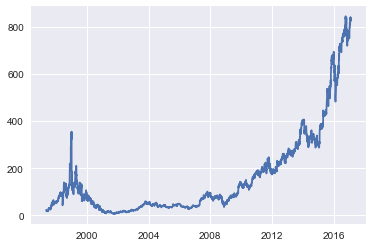

In [25]:
plt.plot(data["Close"])

# Prepare Data

Size of feature matrix:  (1910, 6)
Number of samples: 1910
y:  [1. 1. 1. ... 1. 1. 1.]
len X: 1820
len y: 1820


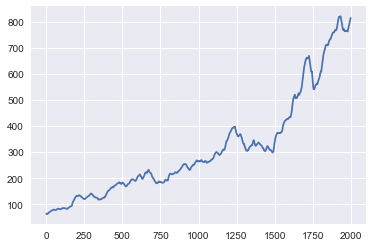

In [26]:
stock_symbol = "AMZN"
days = 90

filename = stock_symbol + ".csv"
csv_file = os.path.join("Dataset", filename)
ohclv_data, close, date = getData(csv_file, days=2000)

plt.plot(ohclv_data[3])

ohclv_data = np.array(ohclv_data)
X, y, xplot, closeplot, dateplot = prepareData(ohclv_data, close, date, days)
y[y == 0] = 1
print("len X:", len(X))
print("len y:", len(y))



1820


(array([ 453.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1367.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

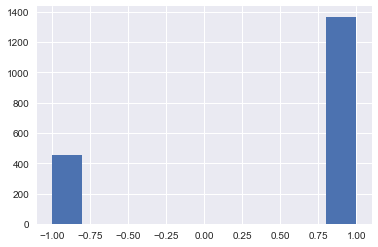

In [27]:
print(len(y))
hist(y)

# Split data

In [28]:
def split_data(X, y, test_factor=0.2):
    # Use the last 20% of the time series as test data.
    # The first elements contains the older data.
    test_len = int(len(X) * test_factor)
    X_test = X[-test_len:]
    y_test = y[-test_len:]
    X_train = X[:-test_len]
    y_train = y[:-test_len]
    return X_train, X_test, y_train, y_test

In [29]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y)
X_train2, X_test2, y_train2, y_test2 = split_data(X, y)

print("n_train1:", len(X_train1))
print("n_test1:", len(X_test1))
print("n_train2:", len(X_train2))
print("n_test2:", len(X_test2))

n_train1: 1365
n_test1: 455
n_train2: 1456
n_test2: 364


# Fit models

In [30]:
model1 = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0)
model1.fit(X_train1, y_train1)
y_pred1 = model1.predict(X_test1)

model2 = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0)
model2.fit(X_train2, y_train2)
y_pred2 = model2.predict(X_test2)

print("model 1 score: %.2f"  % model1.score(X_test1, y_test1))
print("model 2 score: %.2f"  % model2.score(X_test2, y_test2))

model 1 score: 0.93
model 2 score: 0.21


# Evaluate models

In [31]:
Eval1 = Evaluator(X_test1, y_test1, y_pred1, model1)
accuracy, recall, precision, specificity = Eval1.get_performance_metrics()

print("## Confusion matrix metrics ##")
print("Accuracy: %.2f" % accuracy)
print("Recall: %.2f" % recall)
print("Precision: %.2f" % precision)
print("Specificity: %.2f" % specificity)

## Confusion matrix metrics ##
Accuracy: 0.93
Recall: 0.99
Precision: 0.92
Specificity: 0.75


In [32]:
Eval2 = Evaluator(X_test2, y_test2, y_pred2, model2)
accuracy, recall, precision, specificity = Eval2.get_performance_metrics()

print("## Confusion matrix metrics ##")
print("Accuracy: %.2f" % accuracy)
print("Recall: %.2f" % recall)
print("Precision: %.2f" % precision)
print("Specificity: %.2f" % specificity)

## Confusion matrix metrics ##
Accuracy: 0.21
Recall: 0.03
Precision: 1.00
Specificity: 1.00


# Classification result

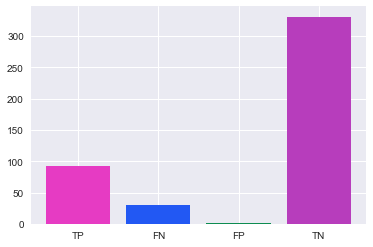

In [33]:
Eval1.plot_classification_results()

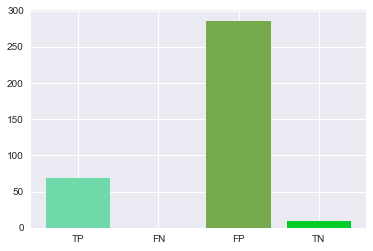

In [34]:
Eval2.plot_classification_results()

# ROC curve using train_test_split (model 1)

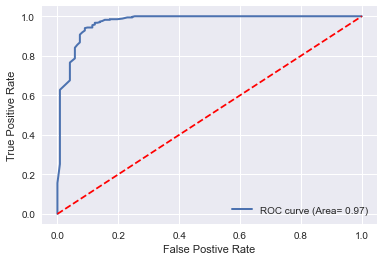

In [35]:
Eval1.draw_ROC(use_probabilities=True)

# ROC curve using split_data (model 2)

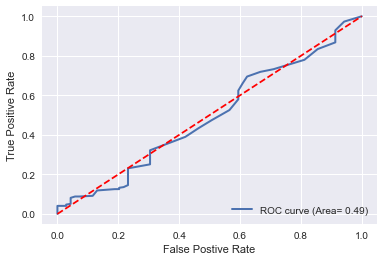

In [36]:
Eval2.draw_ROC(use_probabilities=True)